In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
from scipy.stats import chi2
from scipy.stats import poisson
import copy
import matplotlib as mpl
from matplotlib import cm

In [37]:
#read event
#event_filename=r"E:\CDEX\0vbb\DATA\ROI_Event.txt"
# event_count = len(open(event_filename,'r').readlines())
# event=np.zeros((event_count,))
# with open(event_filename,'r',) as eventf:
#     reader=eventf.readlines()
#     count=0
#     for line in reader:
#         Line=line.split(" ")
#         event[count]=float(Line[0])
#         count+=1
# print(event[np.argwhere(abs(event-2039)<120)])
event=np.loadtxt('E:\CDEX\C1B\CODE\zbt\ROI_event_20210809_33.csv')
event[4:]=0
print(event)

[2019.81 1962.88 2142.31 1953.79    0.      0.      0.      0.      0.
    0.      0.      0.      0.      0.      0.      0.      0.      0.
    0.  ]


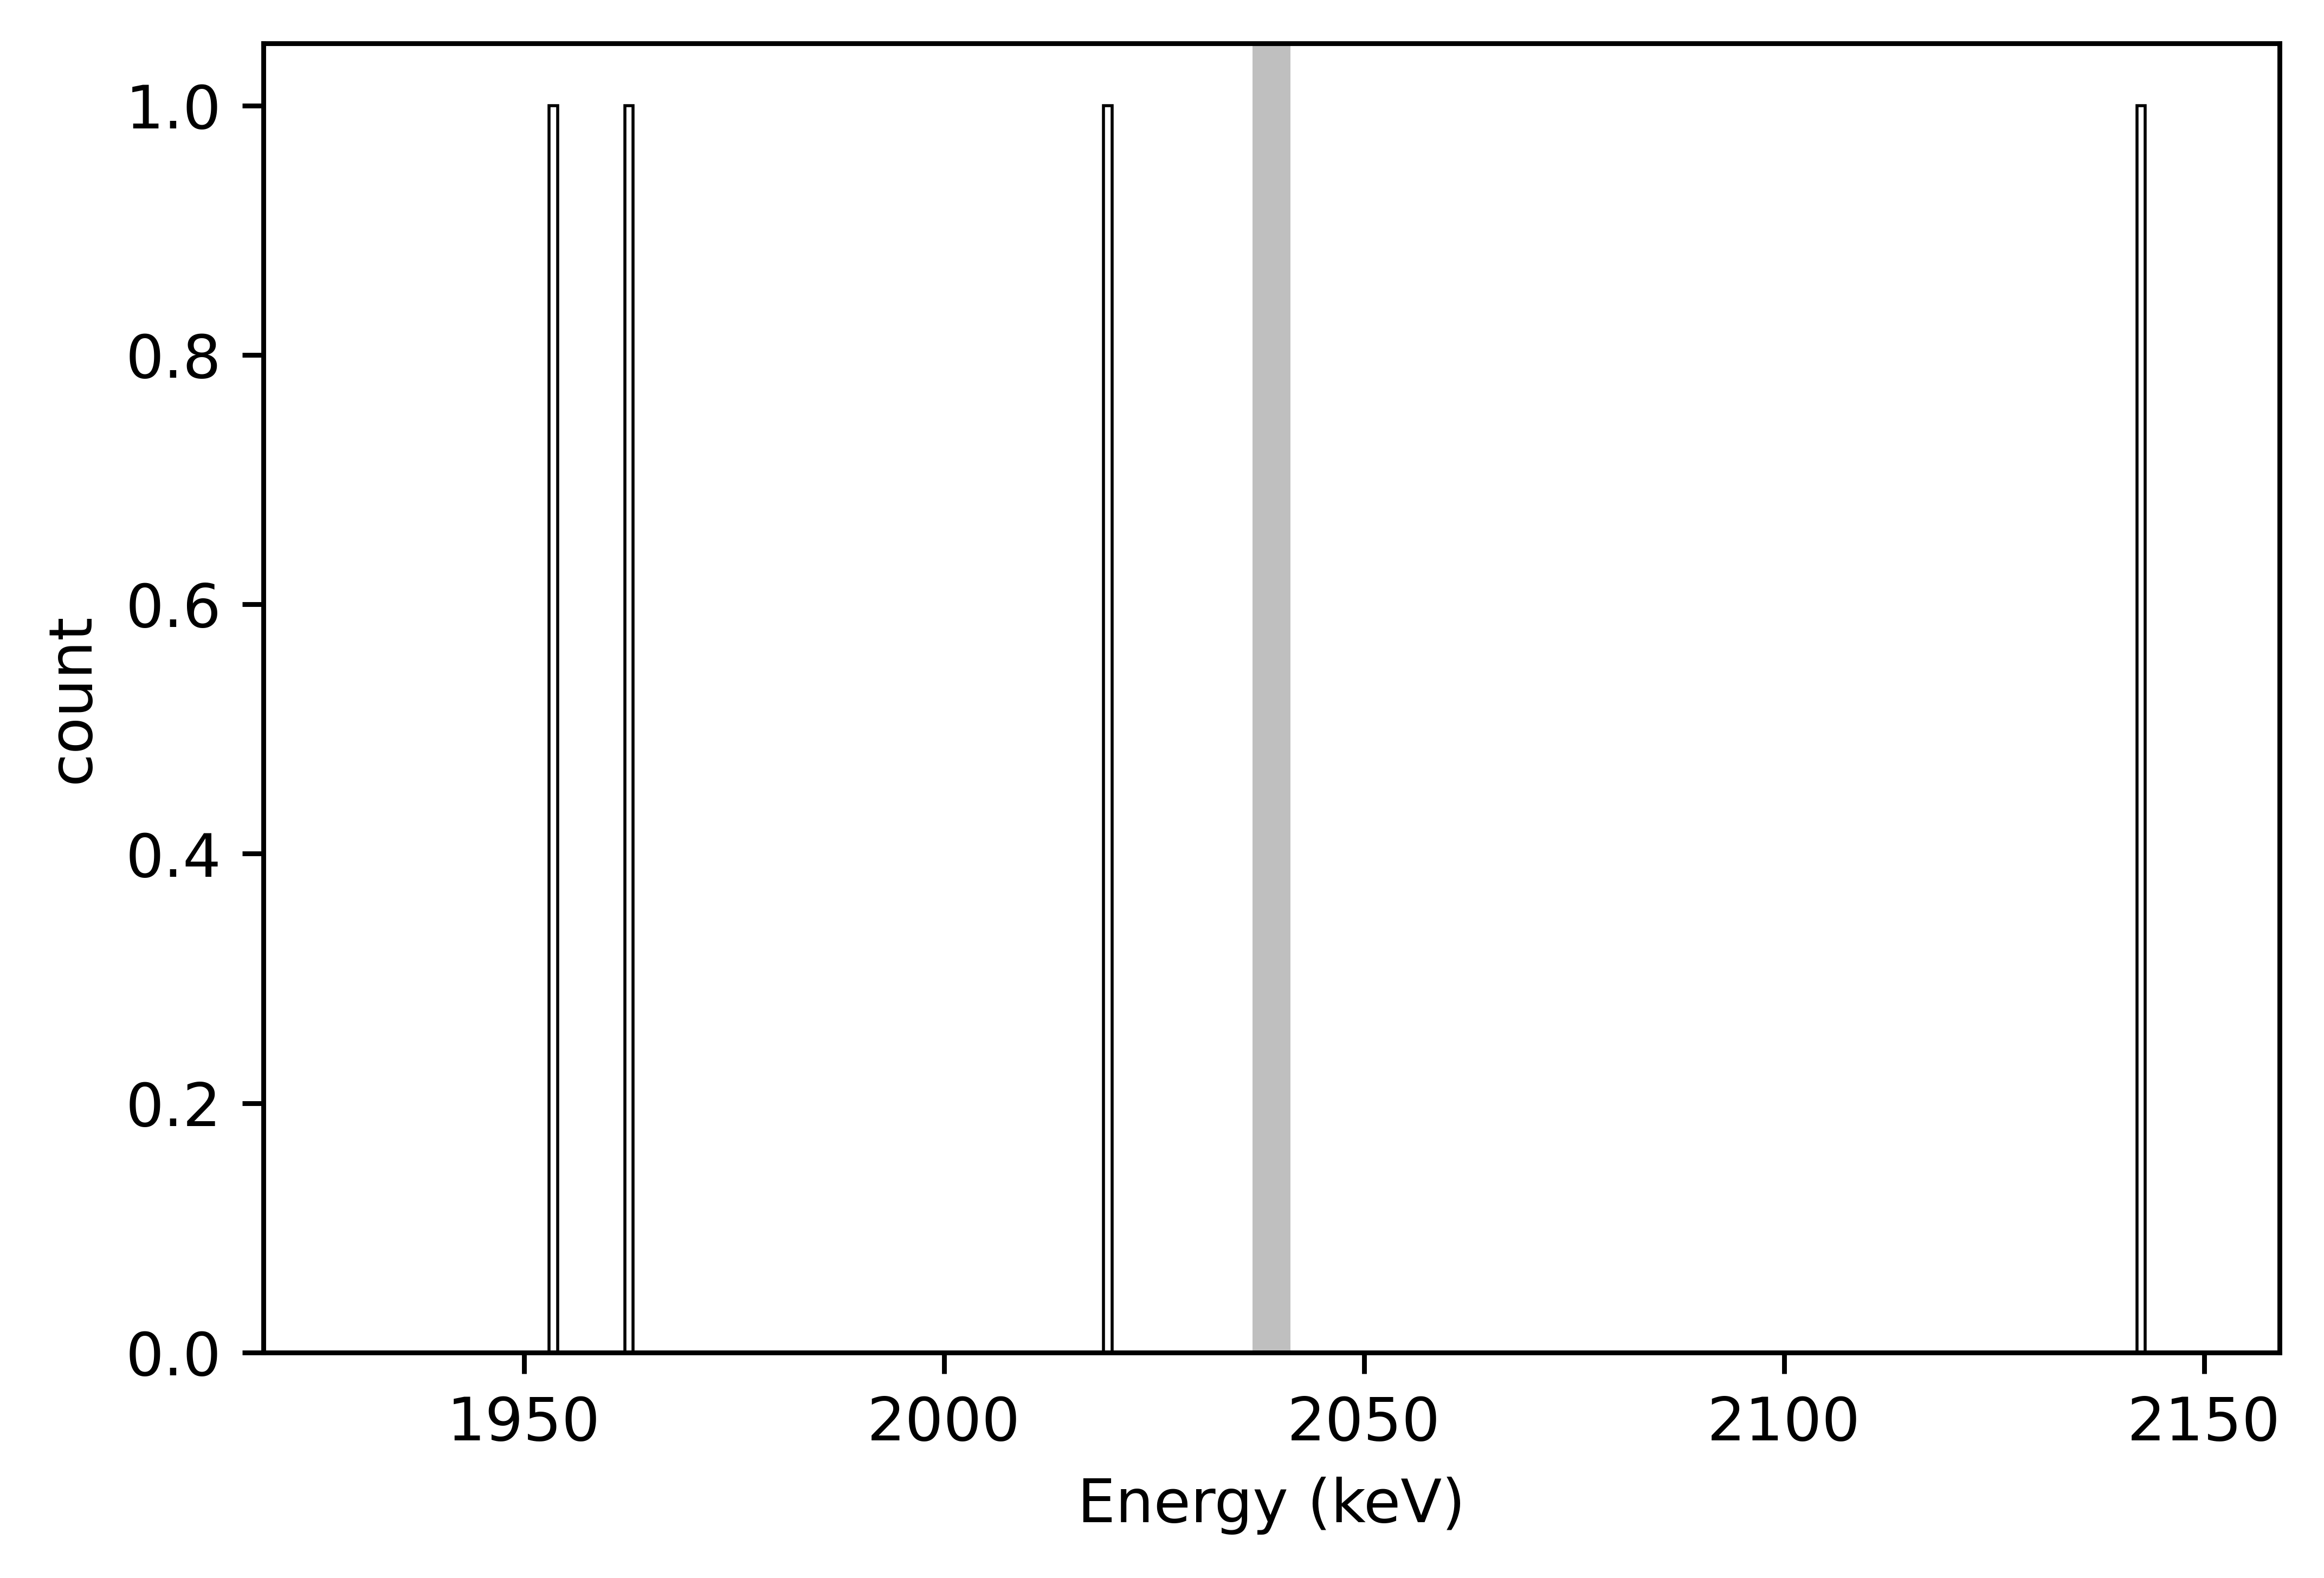

In [38]:
ROIrange=120
fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=800)
spec,bins,patchs=ax.hist(event,bins=240,range=[2039-ROIrange,2039+ROIrange],histtype='step',\
                    linewidth=0.5,color=['black'])
ax.set(xlabel="Energy (keV)",ylabel="count")


###
sigma=4.4/2.355
Q=2039
BI=0.08
sExp=4.56

x=np.linspace(2039-ROIrange,2039+ROIrange,200)

Expect=sExp*np.exp(-(x-Q)**2/(2*sigma**2))/((2*3.1416)**0.5*sigma)+BI
#ax.plot(x,Expect,linestyle='--')
ax.set_xlim(2039-ROIrange,2039+ROIrange)
ax.axvspan(2039-4.5/2,2039+4.5/2,facecolor='0.5',alpha=.5)

plt.show()
#fig.savefig(r"E:\CDEX\0vbb\DATA\20210809_0vbb_spect_240_bkg.png")

In [4]:
##
beta=0.1       #1-beta=0.9
ROI=4.4/2.355*3      #FWHM/2 OR +-3 sigma
vb=0.08*2*ROI        #c/keV* keV
vs=np.logspace(-4,1,1000) #c/keV
Nobs=len(event[np.argwhere(abs(event-2039)<ROI)])

In [5]:
chi_deno=1-chi2.cdf(2*vb,2*(Nobs+1))
chi_nume=1-chi2.cdf(2*(vb+vs),2*(Nobs+1))
p=chi_nume/chi_deno

3.3459891205499748


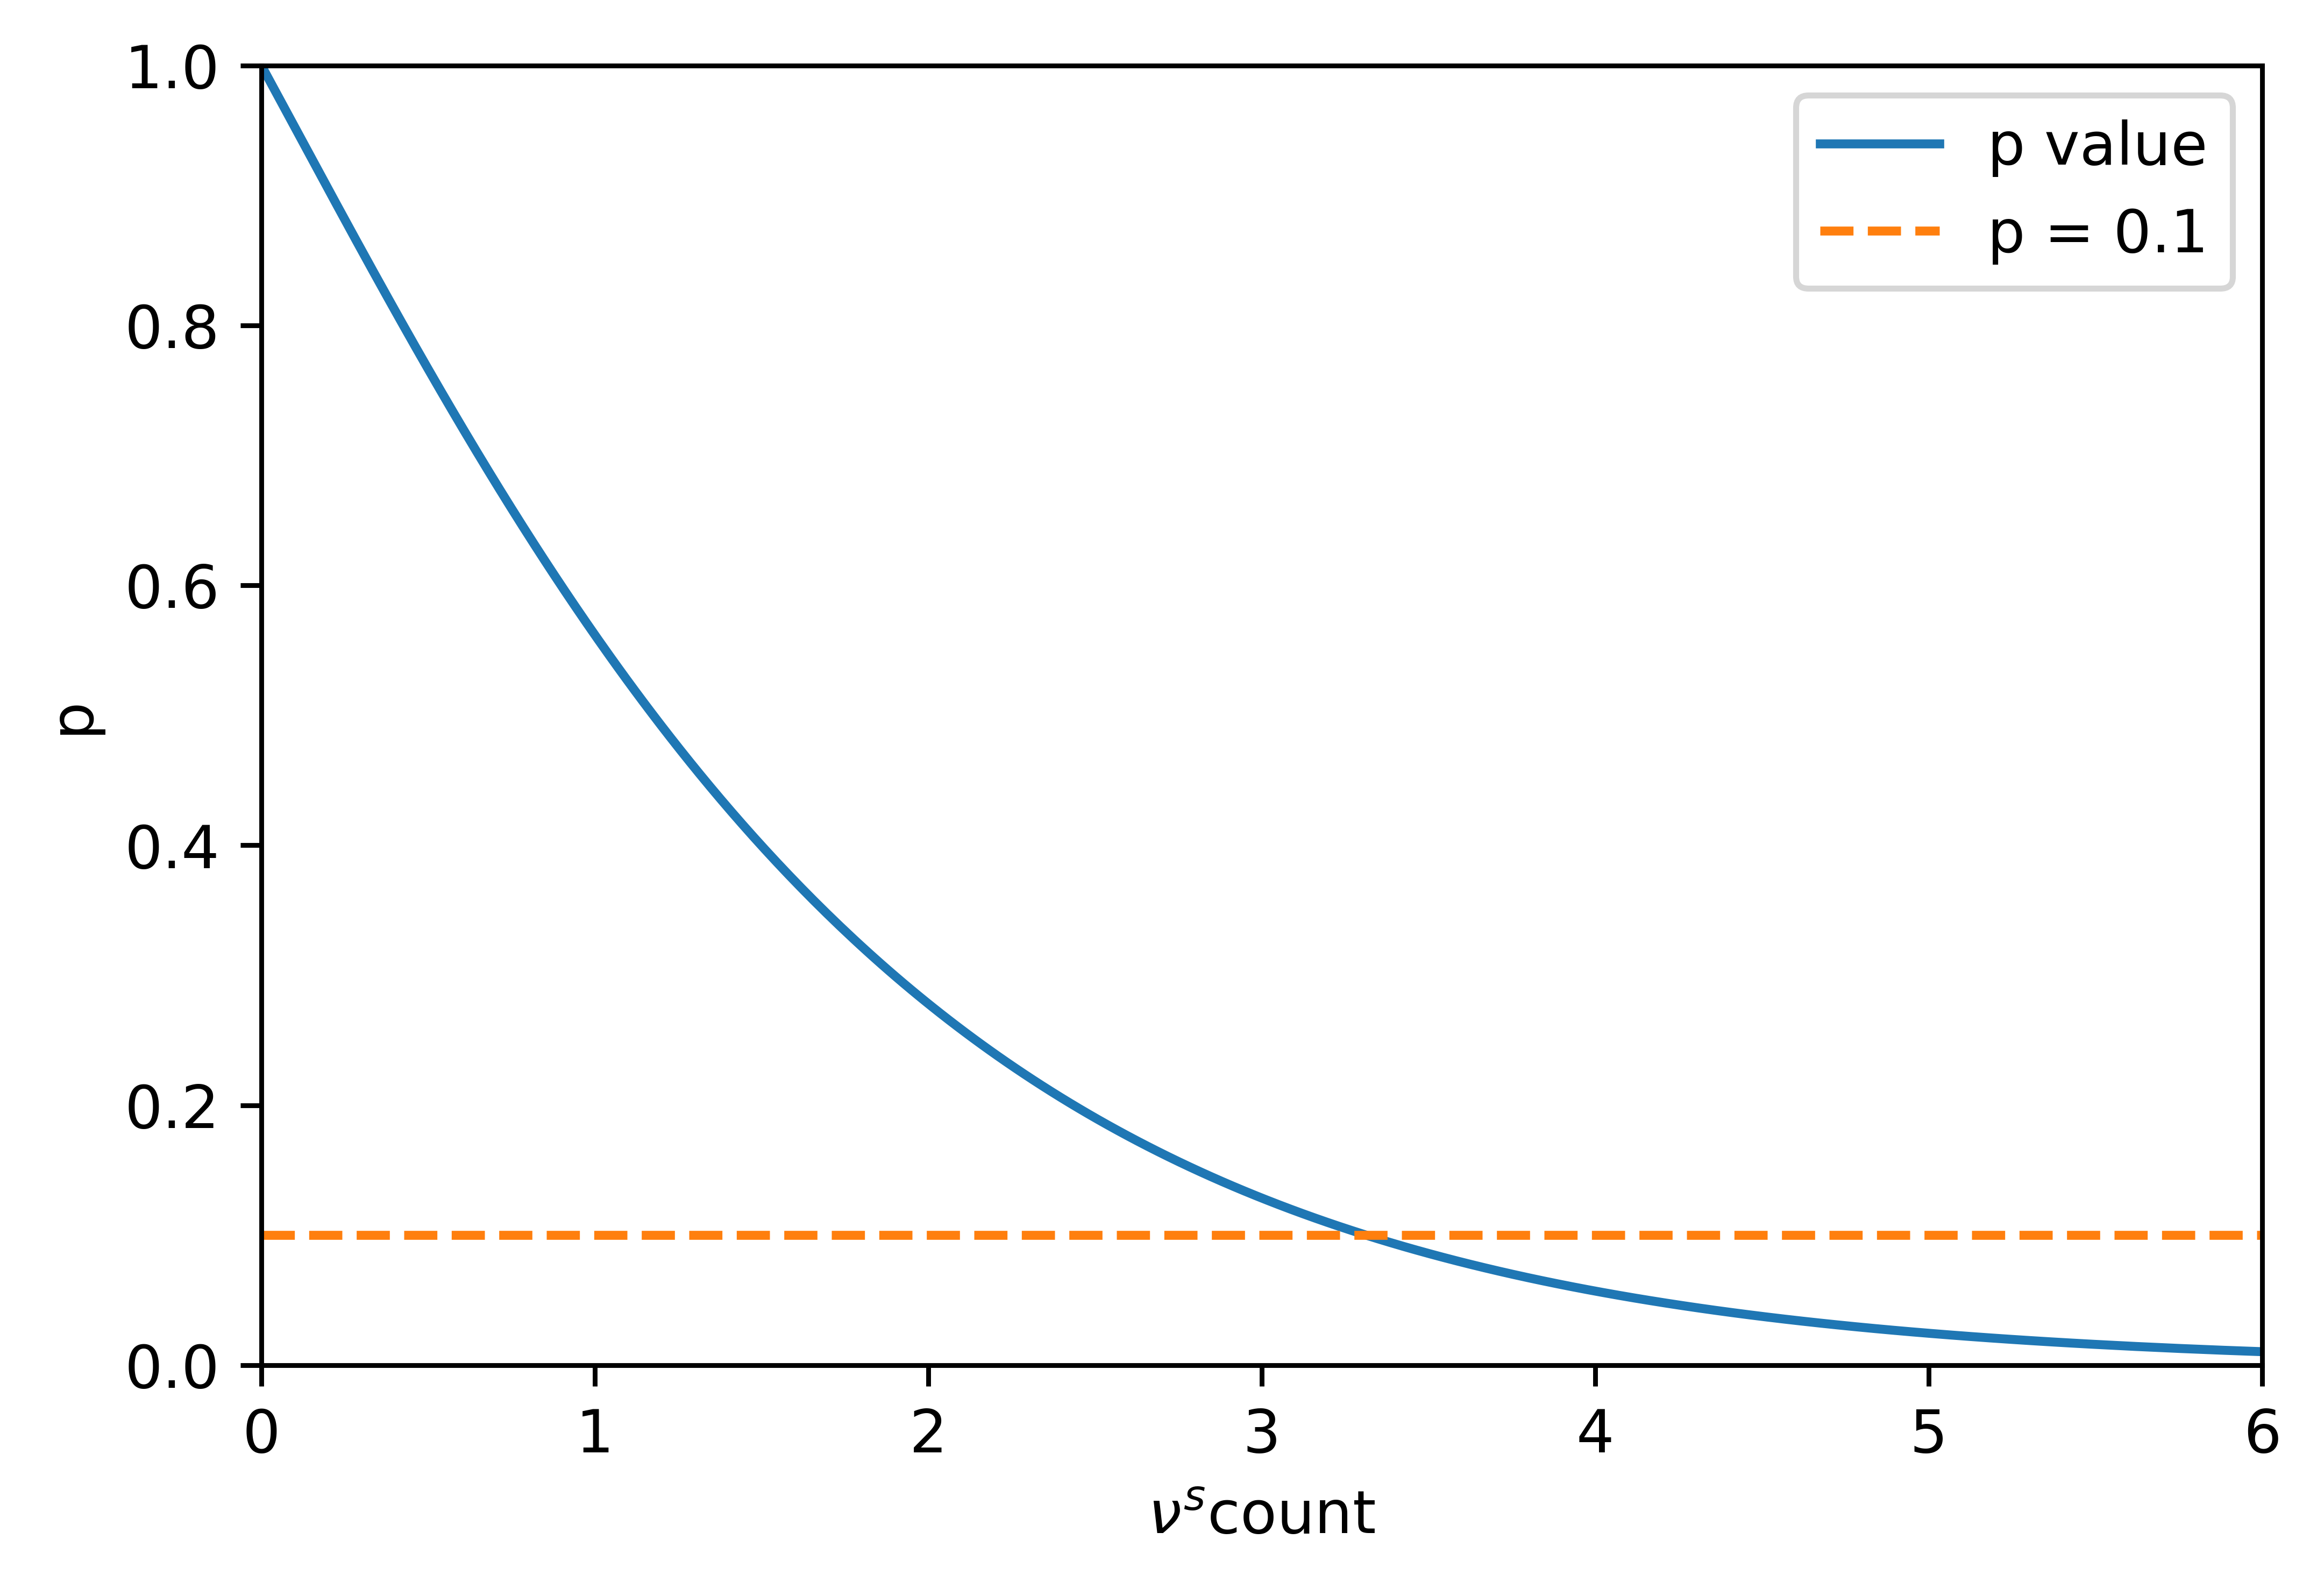

In [12]:
fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=800)
#######t 1/2
# ax.plot(Thalf,p,label="p value")
# ax.set(xlabel=r"$T_{1/2}^{0\nu} (10^{22} $yr)",ylabel="p")
# ax.set_xlim(2,20)
# ax.set_ylim(0,1)
# ax.set_xscale('log')
######vs
ax.plot(vs,p,label="p value")
ax.set(xlabel=r"$\nu^{s}  $count",ylabel="p")
ax.set_xlim(0,6)
ax.set_ylim(0,1)
#########################
ax.plot(vs,np.zeros((len(vs),))+0.1,linestyle='--',label="p = 0.1")
ax.legend()
print(vs[np.where(p<0.1)[0][0]])
#fig.savefig(r"E:\CDEX\0vbb\DATA\0vbb_poisson_t_FWHM_p.png")

In [4]:
class CLs:
    def __init__(self):
        self.deltaE=40
        self.sigma=4.4/2.355
        self.sigma2=3.49
        self.Qbb=2039
        self.sqr_2pisigma=4.68
        self.ksi=0.31      ##kg.yr
        self.NA=6.02e23
        self.ma=0.0726      ##kg/mol
        self.ln2=0.693
        self.BI=0.08
        self.T=0.255
        self.frac=0.0783
        
        
    def L(self,S,B,event):
        #ub=self.ksi*self.deltaE*self.BI
        #us=self.ln2*(self.NA/self.ma)*self.ksi*S
        N=len(event)
        ub=B       #c/keV
        Ns=S       ##expected signal nums
        l=(ub+Ns/self.sqr_2pisigma*np.exp(-(event-self.Qbb)**2/(2*self.sigma2)))/(ub*self.deltaE+Ns)
        return l.prod(axis=0)*poisson.pmf(N,self.deltaE*ub+Ns)
    
    def maxL(self,event,s,b):
        l=np.zeros((len(s),len(b)))
        for i in range(len(s)):
            for j in range(len(b)):
                l[i,j]=self.L(s[i],b[j],event)
        return l
            
    def cal_ts(self,S,event):
        return 0
    def Thalf(self,vs):
        return self.ln2*self.ksi*self.frac*self.NA/(vs*self.ma)*1e-22  
    

In [41]:
cal=CLs()
print(cal.Thalf(1.)*0.52)

7.253037196363636


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


0.009105089351861956
(0, 26)


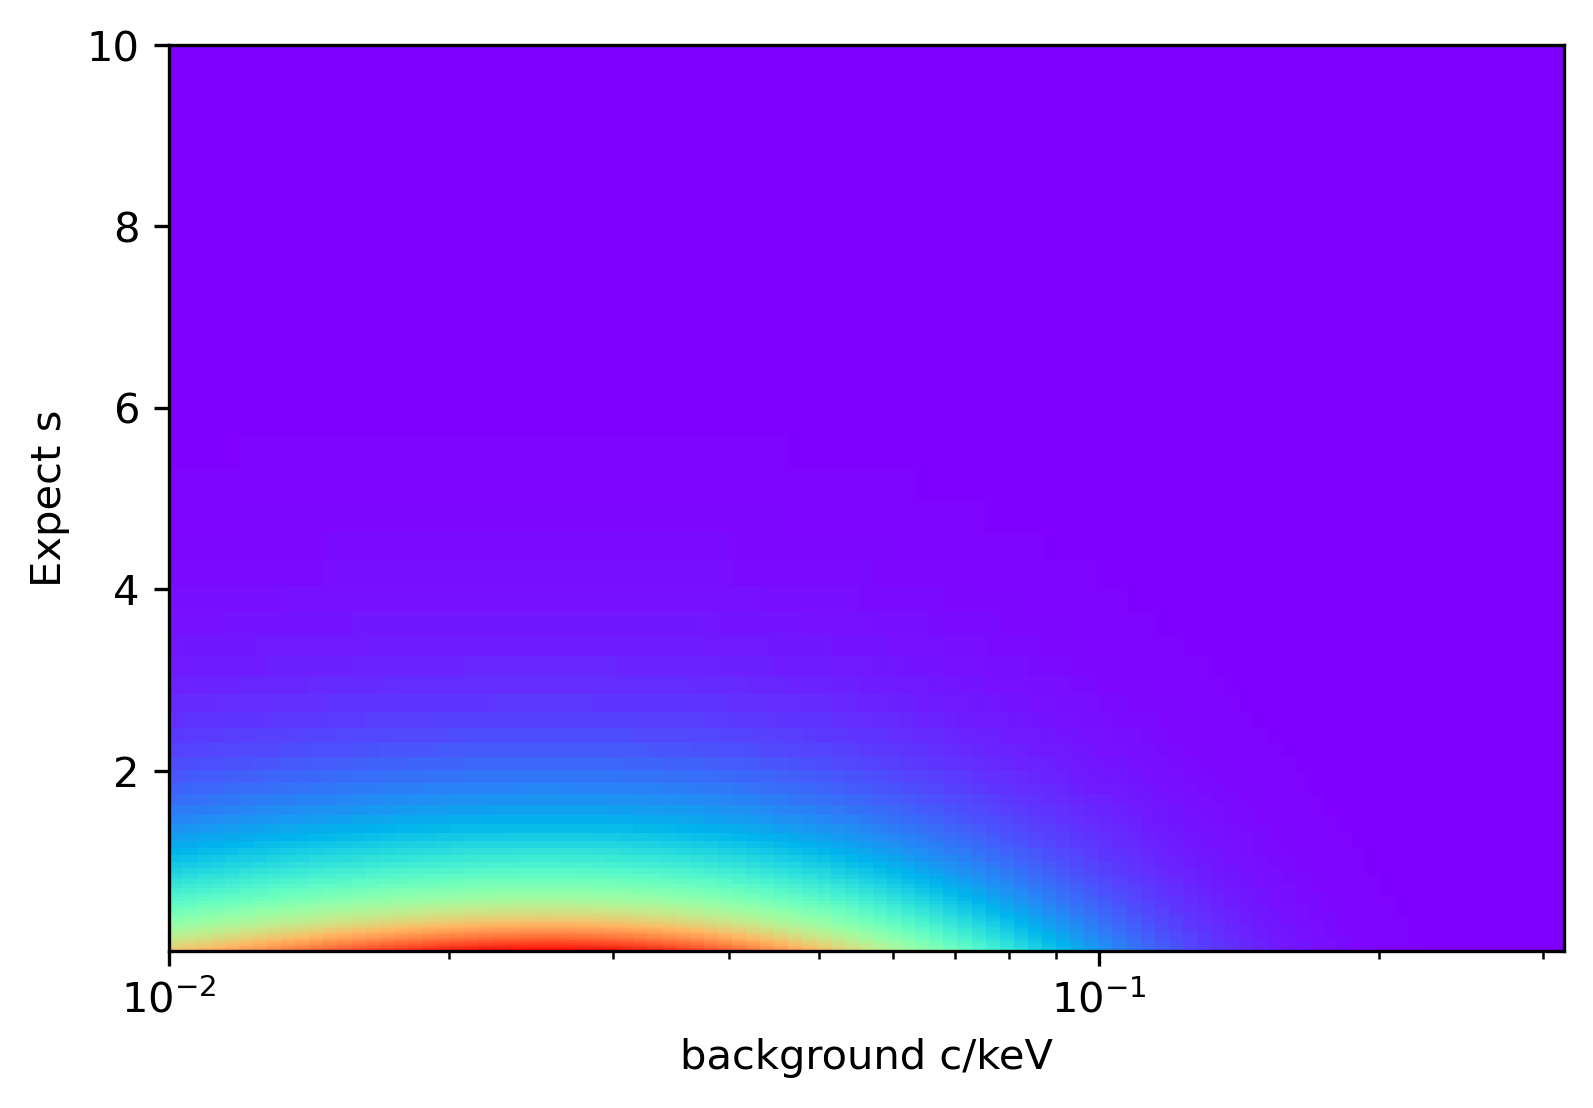

In [39]:
s=np.logspace(-2,1,100)
#s=np.linspace(-,4,500)
b=np.logspace(-2,-0.5,100)
ROIRange=20
l=cal.maxL(event[np.where(abs(event-2039)<ROIRange)],s,b)
fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=300)

ax.set(xlabel="background c/keV",ylabel="Expect s")
#ax.set_yscale('log')
ax.set_xscale('log')
mpl.cm.get_cmap("rainbow")

# cmap_.from_list(name='ra',colors='wgr',gamma=0)
ax.pcolormesh(b,s,l,cmap="rainbow")
for j in range(len(l[0,:])):
    for i in range(len(l[:,0])):
        if(l[i,j]!=l[i,j]):
            l[i,j]=0
index = np.unravel_index(l.argmax(), l.shape)
print(l[index[0]][index[1]])

print(index)


#ax.plot(l[40,:])
# ax.set_xscale('log')

# print(s[np.argmax(l)])
# plt.show()
#fig.savefig(r"E:\CDEX\0vbb\DATA\0vbb_mlh_20210809.svg",format='svg')


In [58]:
print(b[58])

0.07564633275546291


[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.42674075e-01 2.35960207e-01 2.29432086e-01 2.23084573e-01
 2.16912672e-01 2.10911524e-01 2.05076405e-01 1.99402721e-01
 1.93886007e-01 1.88521919e-01 1.83306235e-01 1.78234849e-01
 1.73303769e-01 1.68509113e-01 1.63847107e-01 1.59314081e-01
 1.54906467e-01 1.50620794e-01 1.46453690e-01 1.42401874e-01
 1.38462156e-01 1.34631435e-01 1.30906695e-01 1.27285005e-01
 1.23763514e-01 1.20339448e-01 1.17010114e-01 1.13772889e-01
 1.10625226e-01 1.07564647e-01 1.04588743e-01 1.01695170e-01
 9.88816517e-02 9.61459727e-02 9.34859795e-02 9.08995782e-02
 8.83847328e-02 8.59394636e-02 8.35618457e-02 8.12500074e-02
 7.90021289e-02 7.68164406e-02 7.46912220e-02 7.26248002e-02
 7.06155483e-02 6.86618848e-02 6.67622718e-02 6.49152138e-02
 6.31192568e-02 6.13729872e-02 5.96750302e-02 5.80240492e-02
 5.64187446e-02 5.48578526e-02 5.33401446e-02 5.18644257e-02
 5.04295345e-02 4.90343411e-02 4.76777475e-02 4.63586857e-02
 4.50761173e-02 4.382903

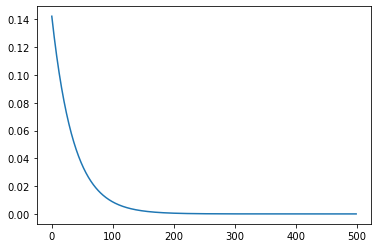

In [36]:
plt.plot(l[:,index[1]+2])
print(l[:,index[1]])
#print(s[np.where(l[:,index[1]]<(0.08*0.1))])

1.4174741629268048


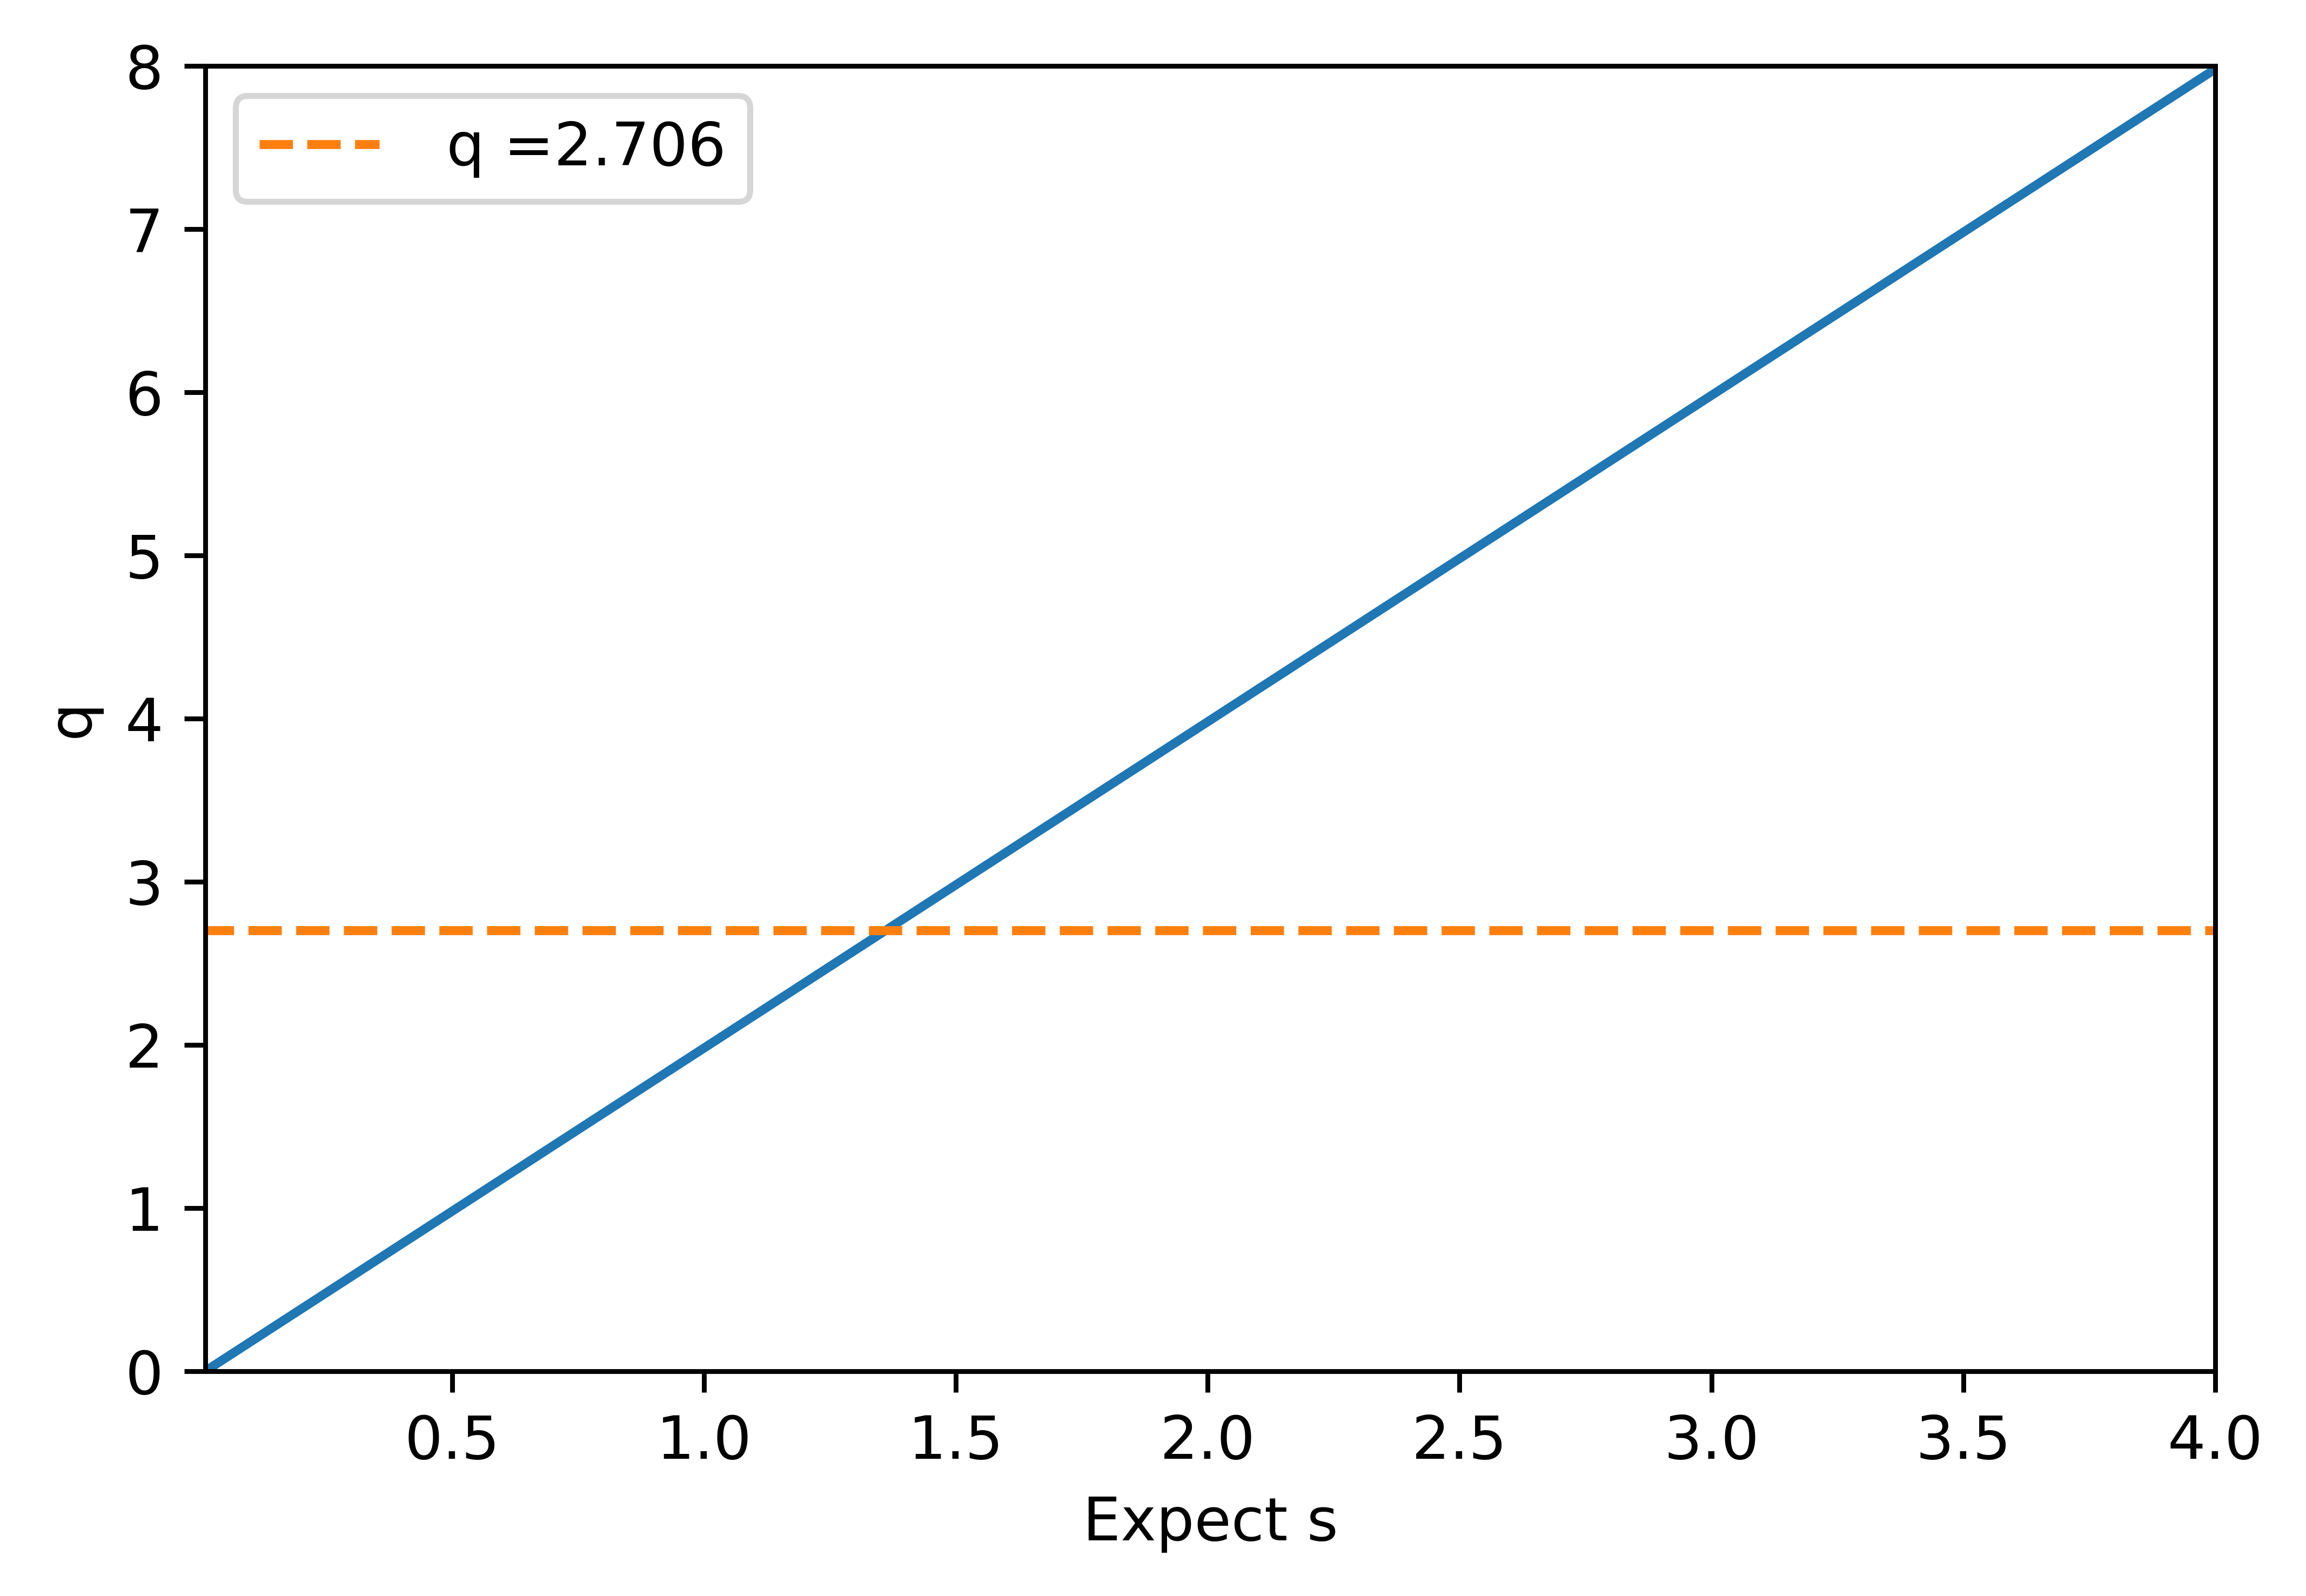

In [40]:

fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=800)
L_numo=np.max(l[index[0]:,:],axis=1)
q=-2*np.log(L_numo/l[index[0]][index[1]])
ax.plot(s[index[0]:],q)

ax.plot(q,np.zeros((len(q),))+2.7,linestyle='--',label=" q =2.706")
ax.set(xlabel="Expect s",ylabel="q")
ax.set_xlim(s[index[0]],4)
ax.set_ylim(0,8)
ax.legend()
print(s[index[0]:][np.where(q>2.7)[0][0]])
#fig.savefig(r"E:\CDEX\0vbb\DATA\0vbb_ql_100_.svg",format='svg')

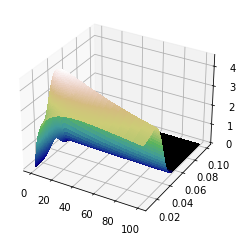

In [221]:
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
import matplotlib.pyplot as plt
import numpy as np

# Load and format data
# dem = cbook.get_sample_data('jacksboro_fault_dem.npz', np_load=True)
# z = dem['elevation']
z=l
nrows, ncols = z.shape
x = s
y = b
x, y = np.meshgrid(x, y)

# region = np.s_[5:50, 5:50]
# x, y, z = x[region], y[region], z[region]

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

ls = LightSource(270, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

plt.show()